In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import tangential_velocity, unit_det


In [2]:
width=500
x = np.linspace(-width // 2, width // 2, 101)
y = np.linspace(-width // 2, width // 2, 101)
X, Y = np.meshgrid(x, y, indexing='ij')

xc, yc = 0.0, 0.0
Q11, Q12, Q22 = 1, 0.4, 1 #.4
psi0 = 250.0
Rc = 85.0
A = - psi0 / Rc**2

# rescale Q to have unit determinant
Q, _ = unit_det(Q=np.array([[Q11, Q12], [Q12, Q22]]))
q11, q12, q22 = Q[0,0], Q[0,1], Q[1,1]

df_res = pd.DataFrame({'xc': [xc], 'yc': [yc], 'w': [2*A*(q11+q22)*1e-3], 'q11': [q11], 'q12': [q12], 'q22': [q22],
                        'Rc': [Rc], 'psi0': [psi0], 'A': [A]})

dx, dy = X - xc, Y - yc
rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
Qr = np.sqrt((q11*dx + q12*dy)**2 + (q12*dx + q22*dy)**2) # ||Qr||
psi = psi0 * np.exp( - rho2 / Rc**2 )
u =   psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q12*dx + 2*q22*dy ) / Rc**2
v = - psi0 * np.exp( - rho2 / Rc**2 ) * ( 2*q11*dx + 2*q12*dy ) / Rc**2

vt_theo = np.abs(2*A*np.exp(-rho2/Rc**2)*Qr)
vt = np.abs(tangential_velocity(X.flatten(), Y.flatten(), u.flatten(), v.flatten(), xc, yc, Q))

df_res


,xc,yc,w,q11,q12,q22,Rc,psi0,A
0,0.0,0.0,-0.000151,1.091089,0.436436,1.091089,85.0,250.0,-0.034602


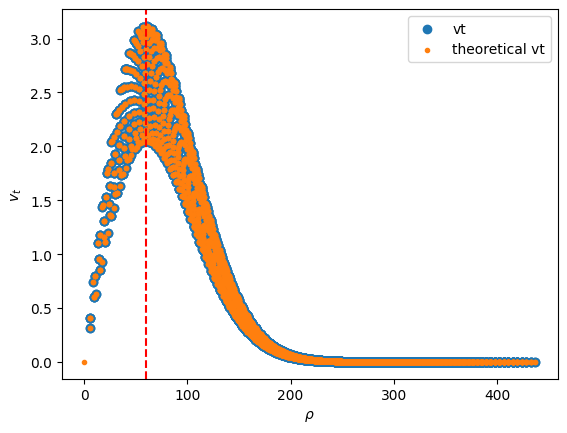

In [3]:
plt.scatter(np.sqrt(rho2), vt, label='vt')
plt.scatter(np.sqrt(rho2), vt_theo, marker='.', label='theoretical vt')
plt.axvline(x=Rc/np.sqrt(2), ls='--', color='r')
plt.legend()
plt.xlabel(r'$\rho$'); plt.ylabel(r'$v_t$');


/scratch/pbs.7077191.kman.restech.unsw.edu.au/ipykernel_287115/1688543674.py:2: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.sqrt(rho2), np.log(vt_theo), marker='.', label='theoretical vt')


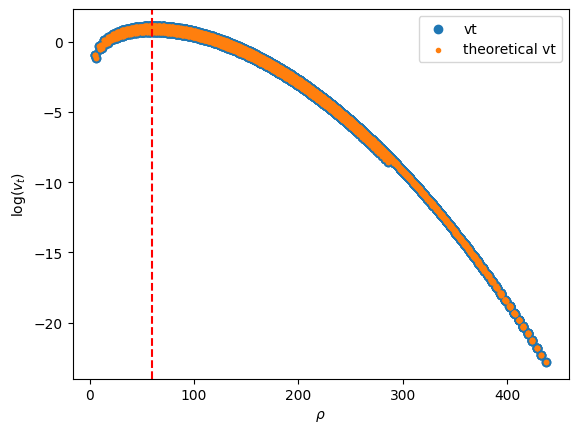

In [4]:
plt.scatter(np.sqrt(rho2), np.log(vt), label='vt')
plt.scatter(np.sqrt(rho2), np.log(vt_theo), marker='.', label='theoretical vt')
plt.legend()
plt.xlabel(r'$\rho$'); plt.ylabel(r'$\log(v_t)$');
plt.axvline(x=Rc/np.sqrt(2), ls='--', color='r')


/scratch/pbs.7077191.kman.restech.unsw.edu.au/ipykernel_287115/3008119030.py:2: RuntimeWarning: divide by zero encountered in log
  plt.scatter(rho2, np.log(vt_theo), marker='.', label='theoretical vt')


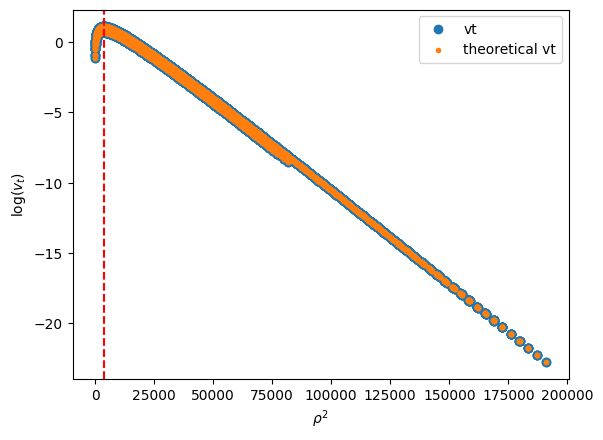

In [5]:
plt.scatter(rho2, np.log(vt), label='vt')
plt.scatter(rho2, np.log(vt_theo), marker='.', label='theoretical vt')
plt.legend()
plt.xlabel(r'$\rho^2$'); plt.ylabel(r'$\log(v_t)$')
plt.axvline(x=Rc**2/2, ls='--', color='r')


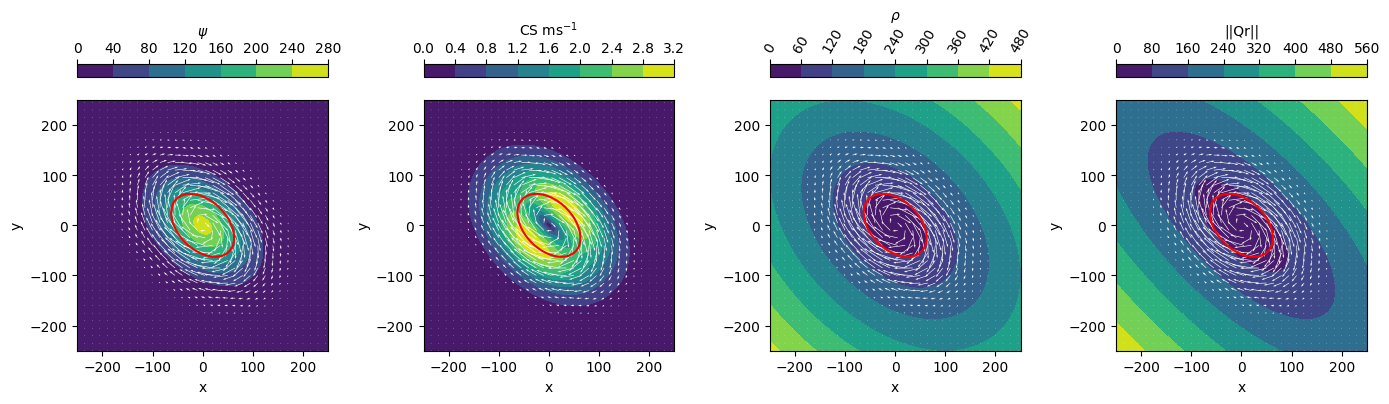

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(14,5))

# First subplot
c0 = axs[0].contourf(X, Y, psi)
fig.colorbar(c0, ax=axs[0], label=r'$\psi$',
             orientation='horizontal', location='top')
spac = 3
axs[0].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[0].contour(X, Y, rho2, colors='r', levels=[Rc**2/2], alpha=1)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].set_aspect('equal')

# Second subplot
c1 = axs[1].contourf(X, Y, np.hypot(u, v))
fig.colorbar(c1, ax=axs[1], label=r'CS ms$^{-1}$',
             orientation='horizontal', location='top')
axs[1].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[1].contour(X, Y, rho2, colors='r', levels=[Rc**2/2], alpha=1)
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].set_aspect('equal')

c2 = axs[2].contourf(X, Y, np.sqrt(rho2))
cb = fig.colorbar(c2, ax=axs[2], label=r'$\rho$',
                  orientation='horizontal', location='top')
cb.ax.tick_params(labelrotation=60)
axs[2].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[2].contour(X, Y, rho2, colors='r', levels=[Rc**2/2], alpha=1)
axs[2].set_xlabel('x')
axs[2].set_ylabel('y')
axs[2].set_aspect('equal')

c3 = axs[3].contourf(X, Y, Qr)
fig.colorbar(c3, ax=axs[3], label='||Qr||',
             orientation='horizontal', location='top')
axs[3].quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
axs[3].contour(X, Y, rho2, colors='r', levels=[Rc**2/2], alpha=1)
axs[3].set_xlabel('x')
axs[3].set_ylabel('y')
axs[3].set_aspect('equal')

plt.tight_layout()
plt.show()


(np.float64(-250.0), np.float64(250.0), np.float64(-250.0), np.float64(250.0))

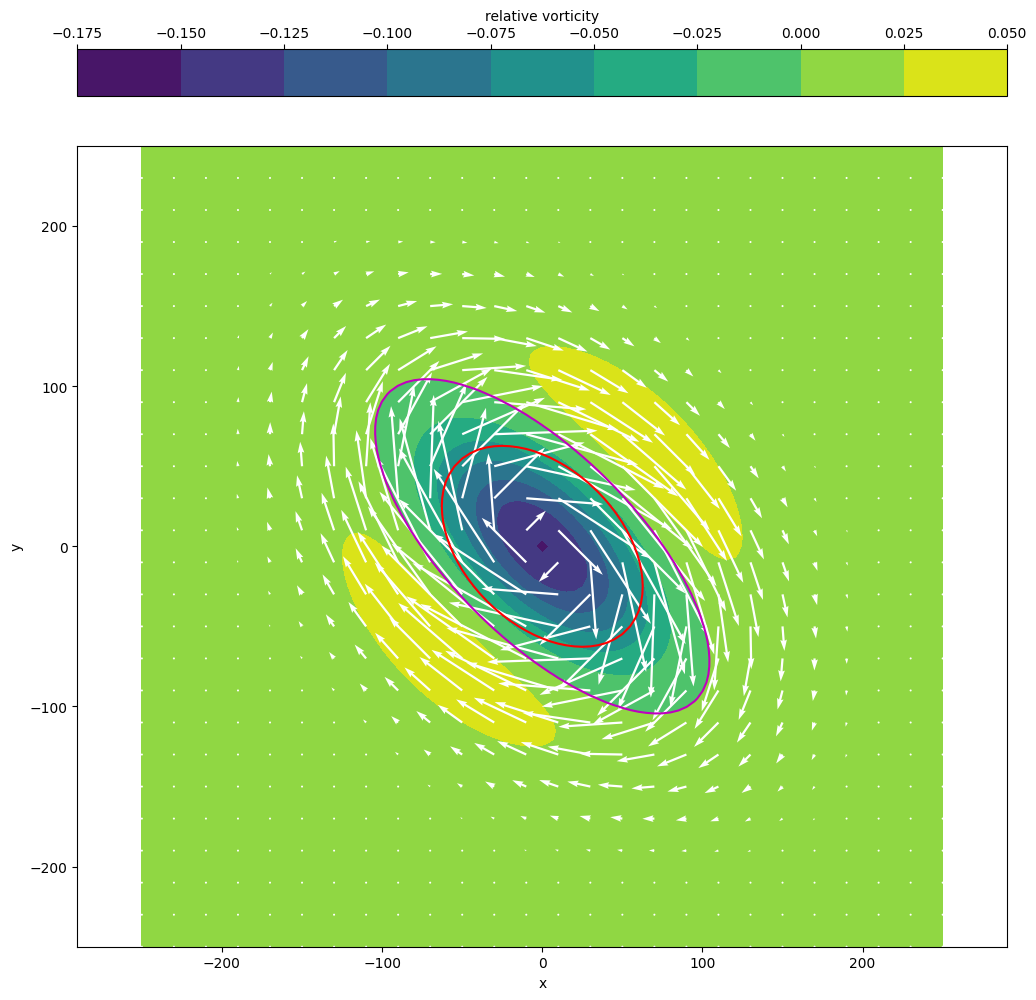

In [7]:
zeta = psi * ( (4.0*Qr**2)/(Rc**4) - (2.0*(q11+q22))/(Rc**2) )
plt.figure(figsize=(12,13))
plt.contourf(X, Y, zeta)
plt.colorbar(label='relative vorticity',
             orientation='horizontal', location='top')
plt.contour(X, Y, zeta, colors='m', levels=[0], alpha=1)
spac = 4
plt.quiver(X[::spac, ::spac], Y[::spac, ::spac],
              u[::spac, ::spac], v[::spac, ::spac], color='white')
plt.contour(X, Y, rho2, colors='r', levels=[Rc**2/2], alpha=1)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
